# 利用MindQuantum实现量子卷积神经网络求解量子多体问题自验报告

## 1. 项目介绍

赛题十五：利用MindQuantum实现量子卷积神经网络求解量子多体问题

论文：
An Application of Quantum Machine Learning on Quantum Correlated Systems: Quantum Convolutional Neural Network as a Classifier for Many-Body Wavefunctions from the Quantum Variational Eigensolver

复现要求：
基于MindQuantum实现图4中的量子卷积神经网络，并在N=4、8、12的情况下实现对顺磁性和铁磁性的分类，精度要求达到90%以上

## 相关信息

### 作者
- rongge ketyxu@126.com
- levitan levitan@msn.cn

### 代码地址
https://gitee.com/levitan3/qcnn_tfi.git

## 复现过程

In [4]:
import src.qcnn as qcn
from src.qcnn import QCNN, StepAcc, LossMonitor   #QCNN：量子卷积神经网络类，StepAcc：监控训练时的模型的准确度，LossMonitor：监控训练中的损失函数

### QCNN的主要结构

- 数据加载和预处理
- 量子电路生成
- 神经网络训练及结果记录

QCNN的初始化会先完成 据加载和预处理 以及量子电路生成。初始化参数包括：qubits：系统比特数，learning_rate：学习率，epoch：训练次数，batch：训练数据块大小，opt：是否优化电路。

In [38]:
from importlib import reload
reload(qcn)
qcnn = qcn.QCNN(qubits=4, learning_rate=0.001, epoch=8, batch=8, opt = False)


Load data finished.
Extended Data shape: (801, 4), (801,), factor: 10


1. 数据加载和预处理

Ising chain的数据来源于tensorflow quantum，有比特数N=4,8,12几组数据，每组数据有81个数据点，对应序参数g在[0.2, 1.8]之间，以0.02的间隔采样。QCNN.load_data()可以加载原始数据，由于原始数据点数不够多，参考文献的做法，我们也进行了插值来扩充数据，QCNN.data_ext()函数可以实现。我们将数据扩充了10倍，即约800个数据，其中640个作为训练集，160个作为验证集。

数据集下载
```python
import tensorflow_quantum as tfq
tfq.datasets.tfi_chain(qubits, boundary_condition='closed', data_dir=None)
```


2. 量子电路生成

量子电路主要包括两部分：encoder 和 ansatz，encoder用于将数据进行编码加载到量子电路上，不可以训练。ansatz部分是量子卷积神经网络的核心部分，包括卷积电路和池化电路。QCNN.gen_encoder()用于实现encoder电路，QCNN.gen_qcnn_ansatz()用于实现ansatz电路，其中卷积电路由QCNN.q_convolution实现，池化电路由QCNN.q_pooling实现

#### encoder电路


In [15]:
encoder = qcnn.gen_encoder()
print(encoder.summary())
encoder.svg()

============================Circuit Summary============================
|Total number of gates  : 20.                                         |
|Parameter gates        : 16.                                         |
|with 4 parameters are  : alpha_0_0, alpha_0_1, alpha_1_0, alpha_1_1. |
|Number qubit of circuit: 4                                           |
None


#### 两比特卷积电路

In [16]:
conv = qcnn.q_convolution('0',[0,1])
print(conv.summary())
conv.svg()

====================================================Circuit Summary====================================================
|Total number of gates  : 15.                                                                                         |
|Parameter gates        : 15.                                                                                         |
|with 14 parameters are : cov_0_0, cov_0_1, cov_0_2, cov_0_3, cov_0_4, cov_0_5, cov_0_6, cov_0_7, cov_0_8, cov_0_9... |
|Number qubit of circuit: 2                                                                                           |
None


#### 两比特池化电路

In [17]:
pol = qcnn.q_pooling('0',[0,1])
print(pol.summary())
pol.svg()

===========================Circuit Summary===========================
|Total number of gates  : 10.                                       |
|Parameter gates        : 9.                                        |
|with 6 parameters are  : p_0_0, p_0_1, p_0_2, p_0_3, p_0_4, p_0_5. |
|Number qubit of circuit: 2                                         |
None


#### 4比特ansatz电路

In [18]:
ansatz_4 = qcnn.gen_qcnn_ansatz()
print(ansatz_4.summary())
ansatz_4.svg()

========================================================================Circuit Summary========================================================================
|Total number of gates  : 75.                                                                                                                                 |
|Parameter gates        : 72.                                                                                                                                 |
|with 60 parameters are : cov_blo_0_0, cov_blo_0_1, cov_blo_0_2, cov_blo_0_3, cov_blo_0_4, cov_blo_0_5, cov_blo_0_6, cov_blo_0_7, cov_blo_0_8, cov_blo_0_9... |
|Number qubit of circuit: 4                                                                                                                                   |
None


### 电路优化

考虑到卷积电路和池化电路相连的时候，有大量的RX，RY，RZ门会重复，因此针对池化电路可以将RX，RY，RZ门去掉（最后一个池化电路输出除外）。

优化后ansatz电路参数对比如下：


| Qubits     | Total number of gates | Total number of gates (optimized)  | Parameter gates  | Parameter gates  (optimized) |
| :---:       |    :----:   |          :---: |  :---: |                :---: | 
| 4      | 75      | 51   | 72 | 48|
| 8   | 175     | 115   | 168 | 108|
| 12   | 275     | 179   | 264 | 168|

优化后的参数门减少了33%~36%。

QCNN只需在初始化时将opt参数设置为True，即可产生优化后的电路，如下：

In [24]:
qcnn = qcn.QCNN(qubits=4, learning_rate=0.001, epoch=8, batch=8, opt = True)
ansatz_4_opt = qcnn.gen_qcnn_ansatz()
print(ansatz_4_opt.summary())
ansatz_4_opt.svg()

Load data finished.
Extended Data shape: (801, 4), (801,), factor: 10
========================================================================Circuit Summary========================================================================
|Total number of gates  : 51.                                                                                                                                 |
|Parameter gates        : 48.                                                                                                                                 |
|with 45 parameters are : cov_blo_0_0, cov_blo_0_1, cov_blo_0_2, cov_blo_0_3, cov_blo_0_4, cov_blo_0_5, cov_blo_0_6, cov_blo_0_7, cov_blo_0_8, cov_blo_0_9... |
|Number qubit of circuit: 4                                                                                                                                   |
None


### 量子卷积神经网络训练及结果

| Qubits     | 4 | 8  | 12  | 
| :---:       |    :----:   |          :---: |  :---: | 
| Accuracy      | 1      | 1   | 0.99| 
| Accuracy(optimized)   | 1     | 1   | 0.99 |
| training time（s）   | 9690     | 25370   | 35909 |
| training time（s, optimized）   | 6830     | 15668   | 25365 |

优化后的训练时间减少了30~38%左右，而分类精度保持与原始方案一样。

#### 4比特训练结果


In [32]:
import time 
qcnn_4 = qcn.QCNN(qubits=4, learning_rate=0.001, epoch=4, batch=8, opt = False)    #未优化电路
qcnn_4_opt = qcn.QCNN(qubits=4, learning_rate=0.001, epoch=4, batch=8, opt = True)  #优化电路

t1 = time.time()
monitor_4 = qcn.LossMonitor(5)                                                       # 监控训练中的损失，每5步打印一次损失值
accu_4 = StepAcc(qcnn_4.model, qcnn_4.test_dataset, qcnn_4.qnet, qubits=4, opt = False)
qcnn_4.train(4, callbacks=[monitor_4,accu_4])
print('qubits 4, used time: %.f'%(time.time()-t1))

Load data finished.
Extended Data shape: (801, 4), (801,), factor: 10
Load data finished.
Extended Data shape: (801, 4), (801,), factor: 10
epoch: 1 step: 5, loss is 0.9682894945144653
epoch: 1 step: 10, loss is 0.9450089931488037
epoch: 1 step: 15, loss is 0.8034152388572693
epoch: 1 step: 20, loss is 0.817954421043396
epoch: 1 step: 25, loss is 0.9211260080337524
epoch: 1 step: 30, loss is 0.8586918115615845
epoch: 1 step: 35, loss is 0.8135753273963928
epoch: 1 step: 40, loss is 0.8486741781234741
epoch: 1 step: 45, loss is 0.8436720967292786
epoch: 1 step: 50, loss is 0.664427638053894
epoch: 1 step: 55, loss is 0.8252289891242981
epoch: 1 step: 60, loss is 0.7058184146881104
epoch: 1 step: 65, loss is 0.5486479997634888
epoch: 1 step: 70, loss is 0.5800719857215881
epoch: 1 step: 75, loss is 0.7760517597198486
epoch: 1 step: 80, loss is 0.6983233690261841
epoch: 2 step: 5, loss is 0.7328165769577026
epoch: 2 step: 10, loss is 0.6195482015609741
epoch: 2 step: 15, loss is 0.5758245

In [6]:
import time 
qcnn_4_opt = qcn.QCNN(qubits=4, learning_rate=0.001, epoch=4, batch=8, opt = True)

Load data finished.
Extended Data shape: (801, 4), (801,), factor: 10


In [28]:
t1 = time.time()
monitor_4_opt = qcn.LossMonitor(5)                                                       # 监控训练中的损失，每5步打印一次损失值
accu_4_opt = StepAcc(qcnn_4_opt.model, qcnn_4_opt.test_dataset, qcnn_4_opt.qnet, qubits=4, opt = True)
qcnn_4_opt.train(4, callbacks=[monitor_4_opt,accu_4_opt])
print('qubits 4 optimized, used time: %.f'%(time.time()-t1))

epoch: 1 step: 5, loss is 0.9770815372467041
epoch: 1 step: 10, loss is 0.963718056678772
epoch: 1 step: 15, loss is 0.8199219107627869
epoch: 1 step: 20, loss is 0.8410197496414185
epoch: 1 step: 25, loss is 0.9376102685928345
epoch: 1 step: 30, loss is 0.8920215368270874
epoch: 1 step: 35, loss is 0.8480380177497864
epoch: 1 step: 40, loss is 0.8764770030975342
epoch: 1 step: 45, loss is 0.8747830986976624
epoch: 1 step: 50, loss is 0.7176844477653503
epoch: 1 step: 55, loss is 0.8509771227836609
epoch: 1 step: 60, loss is 0.7704421281814575
epoch: 1 step: 65, loss is 0.6567880511283875
epoch: 1 step: 70, loss is 0.6361602544784546
epoch: 1 step: 75, loss is 0.8192369937896729
epoch: 1 step: 80, loss is 0.7530521750450134
epoch: 2 step: 5, loss is 0.7851942181587219
epoch: 2 step: 10, loss is 0.6898090839385986
epoch: 2 step: 15, loss is 0.6281898617744446
epoch: 2 step: 20, loss is 0.6223300099372864
epoch: 2 step: 25, loss is 0.7514317035675049
epoch: 2 step: 30, loss is 0.64082902

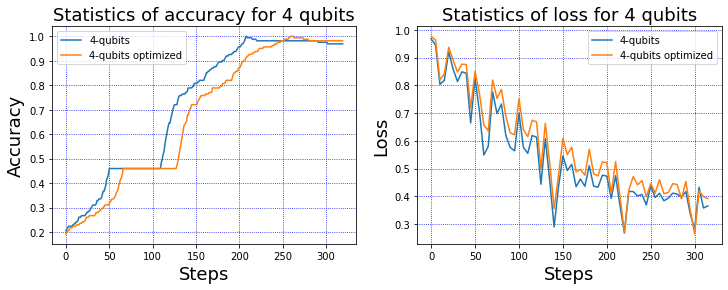

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(accu_4.acc, label='4-qubits')
ax1.plot(accu_4_opt.acc[:len(accu_4.acc)], label='4-qubits optimized')
# ax1.title('Statistics of accuracy for 4 qubits', fontsize=18)
ax1.set_title('Statistics of accuracy for 4 qubits', fontsize=18)
ax1.set_xlabel('Steps', fontsize=18)
ax1.set_ylabel('Accuracy', fontsize=18)
ax1.grid(ls=":",c='b')
ax1.legend()

monitor_4._loss = np.array(monitor_4._loss)
monitor_4_opt._loss = np.array(monitor_4_opt._loss)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(monitor_4._loss[:,0],monitor_4._loss[:,1], label='4-qubits')
ax2.plot(monitor_4_opt._loss[:,0], monitor_4_opt._loss[:,1], label='4-qubits optimized')
ax2.set_title('Statistics of loss for 4 qubits', fontsize=18)
ax2.set_xlabel('Steps', fontsize=18)
ax2.set_ylabel('Loss', fontsize=18)
ax2.grid(ls=":",c='b')
ax2.legend()
plt.show()

#### 8比特训练结果

In [35]:
qcnn_8 = qcn.QCNN(qubits=8, learning_rate=0.005, epoch=4, batch=8, opt = False)    #未优化电路
qcnn_8_opt = qcn.QCNN(qubits=8, learning_rate=0.005, epoch=4, batch=8, opt = True)  #优化电路

t1 = time.time()
monitor_8 = qcn.LossMonitor(5)                                                       # 监控训练中的损失，每5步打印一次损失值
accu_8 = StepAcc(qcnn_8.model, qcnn_8.test_dataset, qcnn_8.qnet, qubits=8, opt = False)
qcnn_8.train(4, callbacks=[monitor_8,accu_8])
print('qubits 8, used time: %.f'%(time.time()-t1))

Load data finished.
Extended Data shape: (801, 8), (801,), factor: 10
Load data finished.
Extended Data shape: (801, 8), (801,), factor: 10
epoch: 1 step: 5, loss is 0.8344307541847229
epoch: 1 step: 10, loss is 0.7263666391372681
epoch: 1 step: 15, loss is 0.6430383920669556
epoch: 1 step: 20, loss is 0.6363404989242554
epoch: 1 step: 25, loss is 0.6507018804550171
epoch: 1 step: 30, loss is 0.6082902550697327
epoch: 1 step: 35, loss is 0.56685471534729
epoch: 1 step: 40, loss is 0.5623493194580078
save model, 0.9503105590062112
save model, 0.9627329192546584
save model, 0.968944099378882
epoch: 1 step: 45, loss is 0.5552025437355042
save model, 0.9813664596273292
save model, 1.0
save model, 0.9937888198757764
save model, 0.9937888198757764
save model, 0.9875776397515528
epoch: 1 step: 50, loss is 0.5284156799316406
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
epoch: 1 step: 5

epoch: 3 step: 75, loss is 0.26593244075775146
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
epoch: 3 step: 80, loss is 0.3076016306877136
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
epoch: 4 step: 5, loss is 0.2911494970321655
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
epoch: 4 step: 10, loss is 0.32503393292427063
save model, 0.9875776397515528
save model, 0.9875776397515528
save model, 0.9937888198757764
save model, 0.9937888198757764
save model, 0.9937888198757764
epoch: 4 step: 15, loss is 0.32270875573158264
save model, 0.9937888198757764
save model, 1.0
save model, 0.9937888198757764
save model, 1.0
save model, 1.0
epoch: 4 step: 20, loss is 0.327404141

In [41]:
t1 = time.time()
monitor_8_opt = qcn.LossMonitor(5)                                                       # 监控训练中的损失，每5步打印一次损失值
accu_8_opt = StepAcc(qcnn_8_opt.model, qcnn_8_opt.test_dataset, qcnn_8_opt.qnet, qubits=8, opt = True)
qcnn_8_opt.train(4, callbacks=[monitor_8_opt,accu_8_opt])
print('qubits 8 optimized, used time: %.f'%(time.time()-t1))

epoch: 1 step: 5, loss is 0.7938011884689331
epoch: 1 step: 10, loss is 0.7072275280952454
epoch: 1 step: 15, loss is 0.6390260457992554
epoch: 1 step: 20, loss is 0.6446629762649536
epoch: 1 step: 25, loss is 0.6604207158088684
epoch: 1 step: 30, loss is 0.6284155249595642
epoch: 1 step: 35, loss is 0.5838932991027832
epoch: 1 step: 40, loss is 0.59130859375
epoch: 1 step: 45, loss is 0.5909777283668518
epoch: 1 step: 50, loss is 0.5051022171974182
epoch: 1 step: 55, loss is 0.4714616537094116
epoch: 1 step: 60, loss is 0.5282713770866394
epoch: 1 step: 65, loss is 0.5352057814598083
epoch: 1 step: 70, loss is 0.4455181658267975
epoch: 1 step: 75, loss is 0.4005580544471741
epoch: 1 step: 80, loss is 0.39643484354019165
epoch: 2 step: 5, loss is 0.37007206678390503


[WARNING] MD(19046,7f68cf7fe700,python):2022-06-19-16:30:43.020.544 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.0163%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(19046,7f6fee724700,python):2022-06-19-16:31:32.384.110 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.0341%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


epoch: 2 step: 10, loss is 0.41782835125923157


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-16:32:22.292.074 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.062%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(19046,7f6ffaf3d700,python):2022-06-19-16:33:09.530.692 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.1062%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(19046,7f677affd700,python):2022-06-19-16:34:01.439.453 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.1325%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' 

epoch: 2 step: 15, loss is 0.4119824767112732
epoch: 2 step: 20, loss is 0.4544089734554291
epoch: 2 step: 25, loss is 0.387177973985672
epoch: 2 step: 30, loss is 0.43103575706481934
epoch: 2 step: 35, loss is 0.4012446105480194
epoch: 2 step: 40, loss is 0.4102359116077423


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-17:00:29.332.763 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.0297%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


epoch: 2 step: 45, loss is 0.43411725759506226


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:01:18.734.699 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.0691%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:02:05.652.707 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.0997%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-17:02:54.945.441 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.1496%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 1.0


[WARNING] MD(19046,7f6ffbf3f700,python):2022-06-19-17:03:35.163.728 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.1504%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(19046,7f6b1d7fa700,python):2022-06-19-17:03:46.609.197 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.1784%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:04:35.817.387 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.2124%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764
epoch: 2 step: 50, loss is 0.4051733613014221


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-17:05:25.110.955 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.2484%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-17:06:14.674.846 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.2957%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6f48fe8700,python):2022-06-19-17:07:04.173.417 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.3236%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f67e67fc700,python):2022-06-19-17:07:53.376.653 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.3654%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f69d2ffd700,python):2022-06-19-17:08:42.506.573 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.4082%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764
epoch: 2 step: 55, loss is 0.34989893436431885


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-17:09:32.742.955 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.4348%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f67c97fa700,python):2022-06-19-17:10:23.000.924 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.4634%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fef726700,python):2022-06-19-17:11:12.538.125 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.5106%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6b9dffb700,python):2022-06-19-17:12:02.212.919 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.5457%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6b9d7fa700,python):2022-06-19-17:12:51.624.429 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.5866%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764
epoch: 2 step: 60, loss is 0.42159706354141235


[WARNING] MD(19046,7f6f49fea700,python):2022-06-19-17:13:38.612.464 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.6088%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fd77fe700,python):2022-06-19-17:14:31.013.699 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.6579%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6ffaf3d700,python):2022-06-19-17:15:20.667.483 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.6928%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6b9e7fc700,python):2022-06-19-17:16:10.301.439 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.7234%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:16:59.668.366 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.7651%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528
epoch: 2 step: 65, loss is 0.4610430598258972


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-17:17:49.438.405 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.8031%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6a927fc700,python):2022-06-19-17:18:38.694.977 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.8299%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6b0b7fe700,python):2022-06-19-17:19:28.885.298 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.8678%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6baa7fc700,python):2022-06-19-17:20:18.483.066 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.899%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f67837fe700,python):2022-06-19-17:21:07.830.656 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.956%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528
epoch: 2 step: 70, loss is 0.389724999666214


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-17:21:57.088.195 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 80.9733%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6bc1ffb700,python):2022-06-19-17:22:46.873.299 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.0191%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:23:36.267.286 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.0577%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6bc3fff700,python):2022-06-19-17:24:28.097.446 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.104%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fd77fe700,python):2022-06-19-17:25:15.313.369 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.1239%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764
epoch: 2 step: 75, loss is 0.32201480865478516


[WARNING] MD(19046,7f69f57fa700,python):2022-06-19-17:26:05.879.335 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.1633%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fef726700,python):2022-06-19-17:26:55.619.635 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.2044%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6b0affd700,python):2022-06-19-17:27:45.003.867 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.2523%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-17:28:34.065.360 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.2892%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fd6ffd700,python):2022-06-19-17:29:23.510.820 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.3159%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528
epoch: 2 step: 80, loss is 0.34862929582595825


[WARNING] MD(19046,7f6713fff700,python):2022-06-19-17:30:13.337.167 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.3638%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6fb97fa700,python):2022-06-19-17:31:02.592.959 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.3883%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6f457e1700,python):2022-06-19-17:31:52.105.225 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.4336%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f69c7fff700,python):2022-06-19-17:32:41.132.962 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.4662%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6f47fe6700,python):2022-06-19-17:33:31.434.882 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.4984%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528
epoch: 3 step: 5, loss is 0.33260440826416016


[WARNING] MD(19046,7f6afaffd700,python):2022-06-19-17:34:20.809.853 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.527%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-17:35:10.072.275 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.5735%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:35:59.465.488 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.6017%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-17:36:49.617.238 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.6386%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f69627fc700,python):2022-06-19-17:37:39.534.974 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.6828%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764
epoch: 3 step: 10, loss is 0.38021302223205566


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-17:38:29.109.909 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.7158%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:39:18.530.567 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.7465%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6b1dffb700,python):2022-06-19-17:40:10.080.240 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.7926%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:40:58.069.453 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.825%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 1.0


[WARNING] MD(19046,7f6b03fff700,python):2022-06-19-17:41:47.923.130 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.8624%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528
epoch: 3 step: 15, loss is 0.36756178736686707


[WARNING] MD(19046,7f6b527fc700,python):2022-06-19-17:42:39.667.746 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.8976%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:43:26.711.844 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 81.9339%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:44:15.868.814 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.0571%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map'

epoch: 3 step: 20, loss is 0.3925831913948059


[WARNING] MD(19046,7f67817fa700,python):2022-06-19-17:46:44.222.185 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.0773%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-17:47:33.655.106 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.123%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6ffc740700,python):2022-06-19-17:48:22.886.646 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.1513%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 1.0


[WARNING] MD(19046,7f6ffa73c700,python):2022-06-19-17:49:12.210.145 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.1855%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f69c67fc700,python):2022-06-19-17:50:03.865.326 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.2332%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764
epoch: 3 step: 25, loss is 0.32166051864624023


[WARNING] MD(19046,7f6789ffb700,python):2022-06-19-17:50:51.339.127 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.2769%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-17:51:41.664.994 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.311%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fd7fff700,python):2022-06-19-17:52:31.253.335 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.3394%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:53:20.863.262 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.3697%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:54:10.825.518 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.402%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528
epoch: 3 step: 30, loss is 0.3870658576488495


[WARNING] MD(19046,7f6831ffb700,python):2022-06-19-17:55:00.217.963 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.4498%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-17:55:50.135.405 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.4873%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-17:56:39.732.302 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.5179%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fd7fff700,python):2022-06-19-17:57:29.045.438 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.5517%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f68a97fa700,python):2022-06-19-17:58:18.285.515 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.6022%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 3 step: 35, loss is 0.38573917746543884


[WARNING] MD(19046,7f6fedf23700,python):2022-06-19-17:59:08.345.362 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.622%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f68827fc700,python):2022-06-19-17:59:58.150.335 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.6636%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f69abfff700,python):2022-06-19-18:00:48.555.057 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.7138%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-18:01:38.306.708 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.7408%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6984ff9700,python):2022-06-19-18:02:27.712.832 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.7774%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 3 step: 40, loss is 0.341999888420105


[WARNING] MD(19046,7f6b497fa700,python):2022-06-19-18:03:19.323.751 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.8176%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b24ff9700,python):2022-06-19-18:04:06.872.468 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.8503%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fef726700,python):2022-06-19-18:04:58.818.596 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.89%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-18:05:47.384.633 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.9209%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fd7fff700,python):2022-06-19-18:06:33.525.460 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.9614%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 3 step: 45, loss is 0.35342925786972046


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-18:07:22.208.590 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 82.9937%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f68037fe700,python):2022-06-19-18:08:11.965.780 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.0363%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6bb9ffb700,python):2022-06-19-18:09:01.371.052 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.0684%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ffbf3f700,python):2022-06-19-18:09:38.805.608 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.0859%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(19046,7f6a93fff700,python):2022-06-19-18:09:52.537.159 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.1155%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6f4c7ef700,python):2022-06-19-18:10:39.127.375 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.1441%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 3 step: 50, loss is 0.3933982253074646


[WARNING] MD(19046,7f6b51ffb700,python):2022-06-19-18:11:27.585.145 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.182%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f69daffd700,python):2022-06-19-18:12:16.786.291 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.2133%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6f48fe8700,python):2022-06-19-18:13:04.986.405 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.2604%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-18:13:53.125.493 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.2826%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6babfff700,python):2022-06-19-18:14:41.421.614 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.3462%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 3 step: 55, loss is 0.3244621157646179


[WARNING] MD(19046,7f6baaffd700,python):2022-06-19-18:15:29.710.684 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.3614%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6f4dff2700,python):2022-06-19-18:16:18.244.779 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.4049%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fbbfff700,python):2022-06-19-18:17:06.503.680 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.445%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-18:17:54.706.279 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.4783%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b267fc700,python):2022-06-19-18:18:42.863.730 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.5332%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 3 step: 60, loss is 0.3690221607685089


[WARNING] MD(19046,7f6fedf23700,python):2022-06-19-18:19:30.970.437 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.5477%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f69f7fff700,python):2022-06-19-18:20:19.715.828 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.5891%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-18:21:07.770.952 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.6167%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-18:21:55.698.563 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.6566%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6f44fe0700,python):2022-06-19-18:22:43.813.594 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.6913%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 3 step: 65, loss is 0.44214871525764465


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-18:23:32.005.161 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.7276%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b037fe700,python):2022-06-19-18:24:20.018.877 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.7675%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fef726700,python):2022-06-19-18:25:05.857.707 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.8063%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6a53fff700,python):2022-06-19-18:25:56.165.343 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.8413%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f69f67fc700,python):2022-06-19-18:26:44.330.816 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.8751%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 3 step: 70, loss is 0.37823840975761414


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-18:27:32.431.165 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.9172%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6f9ffff700,python):2022-06-19-18:28:20.708.557 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.9528%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6f997f2700,python):2022-06-19-18:29:09.011.523 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 83.9792%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6bd77fe700,python):2022-06-19-18:29:57.271.469 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.0246%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f69c7fff700,python):2022-06-19-18:30:45.750.450 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.0666%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 3 step: 75, loss is 0.2725745737552643


[WARNING] MD(19046,7f6b0affd700,python):2022-06-19-18:31:34.189.189 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.1129%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fef726700,python):2022-06-19-18:32:22.308.578 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.1464%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fd77fe700,python):2022-06-19-18:33:10.405.791 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.1651%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-18:33:58.526.081 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.2054%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fedf23700,python):2022-06-19-18:34:46.661.859 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.2444%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 3 step: 80, loss is 0.320912629365921


[WARNING] MD(19046,7f6ffaf3d700,python):2022-06-19-18:35:34.859.904 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.2827%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fedf23700,python):2022-06-19-18:36:23.206.314 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.3217%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6f46fe4700,python):2022-06-19-18:37:11.628.644 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.3663%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b50ff9700,python):2022-06-19-18:37:59.729.614 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.3857%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fedf23700,python):2022-06-19-18:38:47.736.774 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.4257%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 5, loss is 0.3051690459251404


[WARNING] MD(19046,7f6829ffb700,python):2022-06-19-18:39:35.515.698 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.4673%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b26ffd700,python):2022-06-19-18:40:24.122.329 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.5024%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6f4c7ef700,python):2022-06-19-18:41:12.199.444 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.5385%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f69dbfff700,python):2022-06-19-18:42:00.266.230 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.5798%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-18:42:48.238.339 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.6202%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 10, loss is 0.3549688160419464


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-18:43:36.339.085 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.6584%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ffa73c700,python):2022-06-19-18:44:24.533.693 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.674%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fd7fff700,python):2022-06-19-18:45:14.789.378 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.7328%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-18:46:00.577.385 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.768%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f69c4ff9700,python):2022-06-19-18:46:48.654.880 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.7933%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528
epoch: 4 step: 15, loss is 0.3392663598060608


[WARNING] MD(19046,7f6b00ff9700,python):2022-06-19-18:47:34.660.689 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.8302%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f69f7fff700,python):2022-06-19-18:48:24.768.320 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.8801%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-18:49:12.783.997 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.8997%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-18:50:00.933.495 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.9431%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fd77fe700,python):2022-06-19-18:50:51.188.818 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 84.9789%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764
epoch: 4 step: 20, loss is 0.3531344532966614


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-18:51:36.972.378 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.0162%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-18:52:22.932.578 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.0419%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9937888198757764


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-18:53:13.391.907 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.088%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-18:54:01.534.600 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.134%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-18:54:49.699.438 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.1495%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9875776397515528
epoch: 4 step: 25, loss is 0.2807525396347046


[WARNING] MD(19046,7f6ffa73c700,python):2022-06-19-18:55:35.466.051 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.2006%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ff9f3b700,python):2022-06-19-18:56:25.803.509 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.2325%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ff9f3b700,python):2022-06-19-18:57:11.730.348 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.2723%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ff9f3b700,python):2022-06-19-18:58:02.127.815 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.299%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f68a1ffb700,python):2022-06-19-18:58:49.966.971 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.3487%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 30, loss is 0.36172738671302795


[WARNING] MD(19046,7f69c7fff700,python):2022-06-19-18:59:38.001.604 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.3901%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b1d7fa700,python):2022-06-19-19:00:25.896.095 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.4134%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-19:01:13.805.424 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.4436%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-19:02:01.831.894 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.4811%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b1cff9700,python):2022-06-19-19:02:49.745.765 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.5269%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 35, loss is 0.37554699182510376


[WARNING] MD(19046,7f6a50ff9700,python):2022-06-19-19:03:37.561.508 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.5614%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f69abfff700,python):2022-06-19-19:04:25.255.560 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.6015%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fc3fff700,python):2022-06-19-19:05:15.355.111 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.6446%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fef726700,python):2022-06-19-19:06:03.176.070 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.6655%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ffa73c700,python):2022-06-19-19:06:48.942.660 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.705%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 40, loss is 0.3133555054664612


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-19:07:36.847.871 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.7463%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6babfff700,python):2022-06-19-19:08:24.891.898 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.7838%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f67797fa700,python):2022-06-19-19:09:14.870.951 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.8232%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6baa7fc700,python):2022-06-19-19:10:00.666.109 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.8542%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6712ffd700,python):2022-06-19-19:10:48.653.492 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.89%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 45, loss is 0.3245902359485626


[WARNING] MD(19046,7f6b427fc700,python):2022-06-19-19:11:36.552.222 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.9295%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f69f4ff9700,python):2022-06-19-19:12:24.398.994 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 85.9694%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-19:13:12.274.439 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.0025%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ffbf3f700,python):2022-06-19-19:13:48.883.190 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.0134%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(19046,7f6b277fe700,python):2022-06-19-19:13:59.915.244 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.0355%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b1ffff700,python):2022-06-19-19:14:47.769.141 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.0668%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 50, loss is 0.3781734108924866


[WARNING] MD(19046,7f6feef25700,python):2022-06-19-19:15:35.596.935 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.1159%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fd77fe700,python):2022-06-19-19:16:23.224.961 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.1433%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ffaf3d700,python):2022-06-19-19:17:10.880.058 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.1803%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ffa73c700,python):2022-06-19-19:17:58.326.483 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.2146%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ffaf3d700,python):2022-06-19-19:18:45.991.125 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.2584%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 55, loss is 0.318853497505188


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-19:19:33.754.994 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.2843%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-19:20:23.730.444 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.3388%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fd77fe700,python):2022-06-19-19:21:09.223.039 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.3615%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fa7fff700,python):2022-06-19-19:21:57.253.570 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.4032%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ad4ff9700,python):2022-06-19-19:22:45.105.411 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.4622%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 60, loss is 0.3400414288043976


[WARNING] MD(19046,7f6b417fa700,python):2022-06-19-19:23:32.965.296 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.4818%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fee724700,python):2022-06-19-19:24:21.021.470 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.5162%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6ffc740700,python):2022-06-19-19:25:09.014.108 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.5455%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6f4e7f3700,python):2022-06-19-19:25:59.356.480 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.5905%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b03fff700,python):2022-06-19-19:26:44.868.756 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.6473%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 65, loss is 0.4065791964530945


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-19:27:32.821.874 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.668%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f69d0ff9700,python):2022-06-19-19:28:20.871.283 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.6906%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b26ffd700,python):2022-06-19-19:29:09.078.022 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.7383%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fed722700,python):2022-06-19-19:29:57.127.565 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.7761%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6babfff700,python):2022-06-19-19:30:45.179.607 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.8035%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 70, loss is 0.3681197464466095


[WARNING] MD(19046,7f6b01ffb700,python):2022-06-19-19:31:33.185.683 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.8411%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fef726700,python):2022-06-19-19:32:21.347.603 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.8706%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fc1ffb700,python):2022-06-19-19:33:09.443.251 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.9113%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b277fe700,python):2022-06-19-19:33:57.503.573 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 86.9554%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6810ff9700,python):2022-06-19-19:34:45.910.531 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 87.0037%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 75, loss is 0.26186704635620117


[WARNING] MD(19046,7f69c7fff700,python):2022-06-19-19:35:33.969.861 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 87.0288%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f69c67fc700,python):2022-06-19-19:36:22.433.164 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 87.0621%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6b1e7fc700,python):2022-06-19-19:37:10.912.458 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 87.1058%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f67897fa700,python):2022-06-19-19:38:01.287.369 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 87.1369%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292


[WARNING] MD(19046,7f6fecf21700,python):2022-06-19-19:38:46.999.785 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 87.1737%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
epoch: 4 step: 80, loss is 0.313529908657074


[WARNING] MD(19046,7f6a53fff700,python):2022-06-19-19:39:34.963.770 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:135] operator()] Memory consumption is more than 87.2131%, which may cause oom error. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


save model, 0.9813664596273292
qubits 8 optimized, used time: 15668


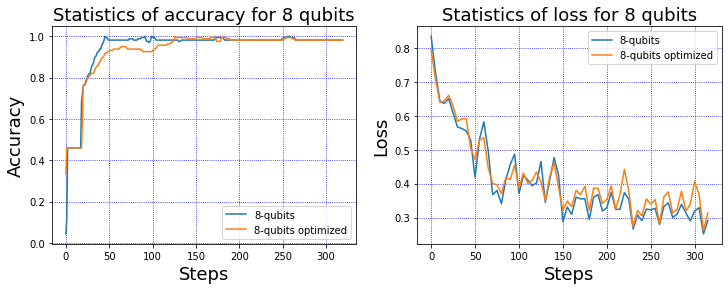

In [79]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(accu_8.acc, label='8-qubits')
ax1.plot(accu_8_opt.acc[:len(accu_8.acc)], label='8-qubits optimized')
# ax1.title('Statistics of accuracy for 4 qubits', fontsize=18)
ax1.set_title('Statistics of accuracy for 8 qubits', fontsize=18)
ax1.set_xlabel('Steps', fontsize=18)
ax1.set_ylabel('Accuracy', fontsize=18)
ax1.grid(ls=":",c='b')
ax1.legend()

monitor_8._loss = np.array(monitor_8._loss)
monitor_8_opt._loss = np.array(monitor_8_opt._loss)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(monitor_8._loss[:,0],monitor_8._loss[:,1], label='8-qubits')
ax2.plot(monitor_8_opt._loss[:,0], monitor_8_opt._loss[:,1], label='8-qubits optimized')
ax2.set_title('Statistics of loss for 8 qubits', fontsize=18)
ax2.set_xlabel('Steps', fontsize=18)
ax2.set_ylabel('Loss', fontsize=18)
ax2.grid(ls=":",c='b')
ax2.legend()
plt.show()

#### 12比特训练结果

In [8]:
qcnn_12 = qcn.QCNN(qubits=12, learning_rate=0.01, epoch=4, batch=8, opt = False)    #未优化电路
qcnn_12_opt = qcn.QCNN(qubits=12, learning_rate=0.01, epoch=4, batch=8, opt = True)  #优化电路

t1 = time.time()
monitor_12 = qcn.LossMonitor(5)                                                       # 监控训练中的损失，每5步打印一次损失值
accu_12 = StepAcc(qcnn_12.model, qcnn_12.test_dataset, qcnn_12.qnet, qubits=12, opt = False)
qcnn_12.train(4, callbacks=[monitor_12,accu_12])
print('qubits 12, used time: %.f'%(time.time()-t1))

Load data finished.
Extended Data shape: (801, 12), (801,), factor: 10
Load data finished.
Extended Data shape: (801, 12), (801,), factor: 10
epoch: 1 step: 5, loss is 0.823477029800415
epoch: 1 step: 10, loss is 0.6966296434402466
epoch: 1 step: 15, loss is 0.6564149856567383
epoch: 1 step: 20, loss is 0.6589954495429993
epoch: 1 step: 25, loss is 0.5579617619514465
epoch: 1 step: 30, loss is 0.6020314693450928
epoch: 1 step: 35, loss is 0.5717231631278992
epoch: 1 step: 40, loss is 0.5296252965927124
epoch: 1 step: 45, loss is 0.5218836069107056
epoch: 1 step: 50, loss is 0.6347401738166809
epoch: 1 step: 55, loss is 0.42691370844841003
epoch: 1 step: 60, loss is 0.5654643774032593
epoch: 1 step: 65, loss is 0.6942960023880005
epoch: 1 step: 70, loss is 0.531991720199585
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
epoch: 1 step: 75, loss is 0.3720463514328003
save model, 0.9

save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
epoch: 4 step: 80, loss is 0.31929492950439453
save model, 0.9813664596273292
qubits 12, used time: 35909


In [9]:
t1 = time.time()
monitor_12_opt = qcn.LossMonitor(5)                                                       # 监控训练中的损失，每5步打印一次损失值
accu_12_opt = StepAcc(qcnn_12_opt.model, qcnn_12_opt.test_dataset, qcnn_12_opt.qnet, qubits=12, opt = True)
qcnn_12_opt.train(4, callbacks=[monitor_12_opt,accu_12_opt])
print('qubits 12 optimized, used time: %.f'%(time.time()-t1))

epoch: 1 step: 5, loss is 0.8487699627876282
epoch: 1 step: 10, loss is 0.7212374806404114
epoch: 1 step: 15, loss is 0.6658421158790588
epoch: 1 step: 20, loss is 0.6713472604751587
epoch: 1 step: 25, loss is 0.6403016448020935
epoch: 1 step: 30, loss is 0.6377034187316895
epoch: 1 step: 35, loss is 0.5982828736305237
epoch: 1 step: 40, loss is 0.5655609369277954
epoch: 1 step: 45, loss is 0.5617476105690002
epoch: 1 step: 50, loss is 0.6870285868644714
epoch: 1 step: 55, loss is 0.449368417263031
epoch: 1 step: 60, loss is 0.6146565675735474
epoch: 1 step: 65, loss is 0.7922105193138123
epoch: 1 step: 70, loss is 0.6336759328842163
epoch: 1 step: 75, loss is 0.3856649100780487
epoch: 1 step: 80, loss is 0.43412917852401733
epoch: 2 step: 5, loss is 0.3773481249809265
epoch: 2 step: 10, loss is 0.48736754059791565
epoch: 2 step: 15, loss is 0.5012590885162354
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
sav

save model, 0.9813664596273292
save model, 0.9813664596273292
epoch: 4 step: 70, loss is 0.4277302026748657
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9813664596273292
save model, 0.9875776397515528
save model, 0.9875776397515528
epoch: 4 step: 75, loss is 0.2861991226673126
save model, 0.9875776397515528
save model, 0.9875776397515528
save model, 0.9875776397515528
save model, 0.9813664596273292
save model, 0.9813664596273292
epoch: 4 step: 80, loss is 0.31840935349464417
save model, 0.9813664596273292
qubits 12 optimized, used time: 25365


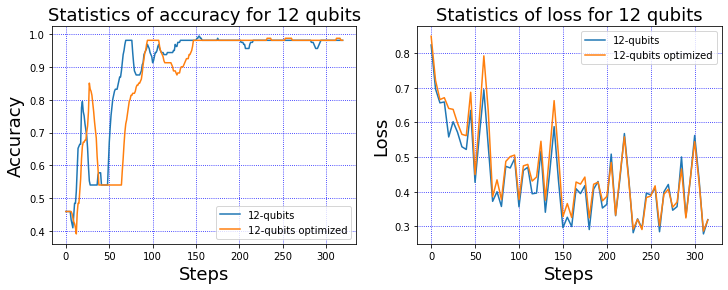

In [19]:
import numpy as np
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(accu_12.acc, label='12-qubits')
ax1.plot(accu_12_opt.acc, label='12-qubits optimized')
# ax1.title('Statistics of accuracy for 4 qubits', fontsize=18)
ax1.set_title('Statistics of accuracy for 12 qubits', fontsize=18)
ax1.set_xlabel('Steps', fontsize=18)
ax1.set_ylabel('Accuracy', fontsize=18)
ax1.grid(ls=":",c='b')
ax1.legend()

monitor_12._loss = np.array(monitor_12._loss)
monitor_12_opt._loss = np.array(monitor_12_opt._loss)
ax2 = fig.add_subplot(1,2,2)
ax2.plot(monitor_12._loss[:,0],monitor_12._loss[:,1], label='12-qubits')
ax2.plot(monitor_12_opt._loss[:,0], monitor_12_opt._loss[:,1], label='12-qubits optimized')
ax2.set_title('Statistics of loss for 12 qubits', fontsize=18)
ax2.set_xlabel('Steps', fontsize=18)
ax2.set_ylabel('Loss', fontsize=18)
ax2.grid(ls=":",c='b')
ax2.legend()
plt.show()